# CSCI 250: Project 5 - Lucy Buhayenko

# Importing Libraries

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn import decomposition
from sklearn.decomposition import PCA
import plotly.express as px

# Mall Customers Dataset

In [4]:
df = pd.read_csv("Mall_Customers.csv")

In [5]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# There are no missing values so there is no need for me to delete / replace any points

In [6]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

# Dropping features ID and Gender because I'll be doing Kmeans:
### ID is just an identifier and Gender is categorical value so I drop them

In [7]:
X = df.drop(['CustomerID', 'Gender'], axis=1)

# Standardize the data

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Scatter Plot for X
### From the scatter plot of the data, there are no clearly visible cluster patterns or groupings. The points appear to be spread out without obvious separation. This means that the data may not have strong natural clusters in these two dimensions, or that potential clusters might only become visible when considering additional features or transformations (like PCA)

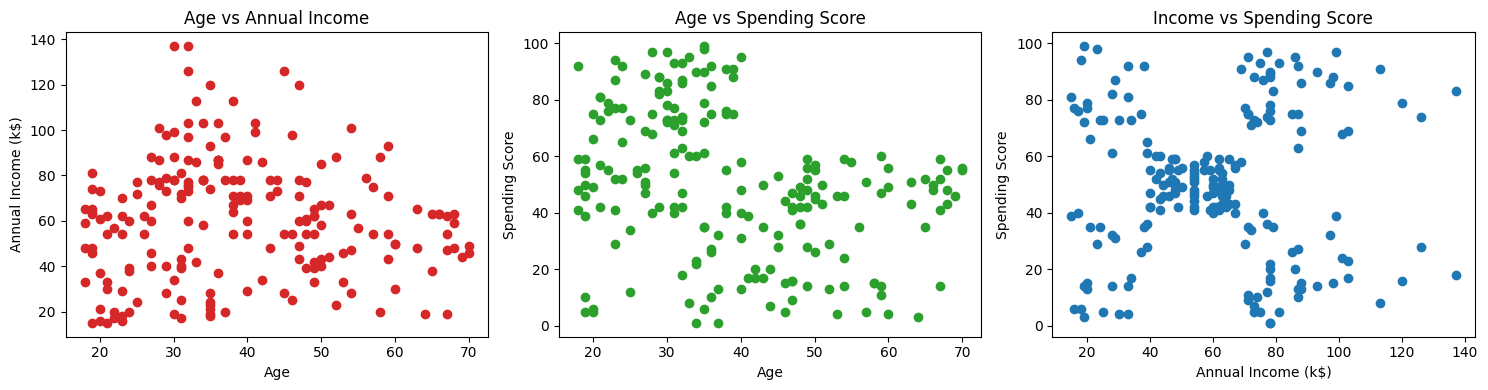

In [9]:
#scatter plot for 3 cases (age vs annual income and age vs spending score and income vs spending score)
plt.figure(figsize=(15, 4))

# 1. Age vs Annual Income
plt.subplot(1, 3, 1)
plt.scatter(df["Age"], df["Annual Income (k$)"], color='tab:red')
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
plt.title("Age vs Annual Income")

# 2. Age vs Spending Score
plt.subplot(1, 3, 2)
plt.scatter(df["Age"], df["Spending Score (1-100)"], color='tab:green')
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.title("Age vs Spending Score")

# 3. Annual Income vs Spending Score
plt.subplot(1, 3, 3)
plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"], color='tab:blue')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score")
plt.title("Income vs Spending Score")

plt.tight_layout()
plt.show()

# Find the best number of clusters for the K mean model

### In this case the best number of clusters for the K mean is 4. I chose k=4 as the optimal number of clusters because it represents the point where the inertia decreases rapidly and then begins to level off. Adding more clusters after 4 didn’t really improve the results much, so it seemed unnecessary. Therefore, k=4 gives me the best balance between simplicity and good clustering.

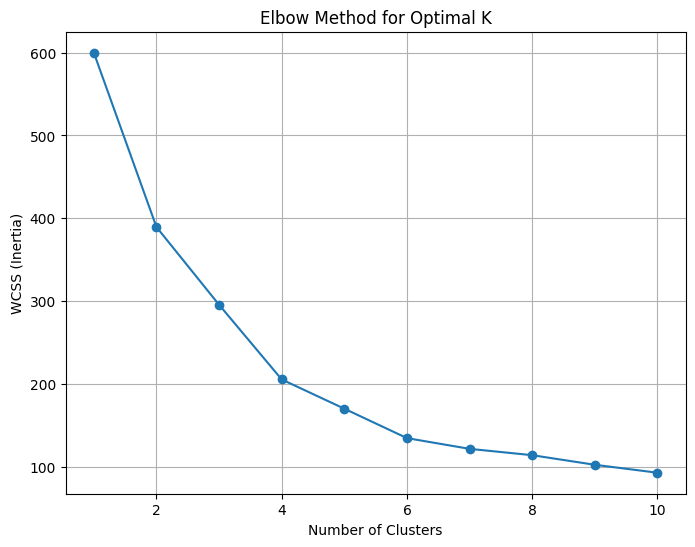

WCSS values for 1 to 10 clusters: [600.0, 389.3861889564372, 295.4562449213556, 205.22514747675916, 169.89149793438582, 134.3527747740149, 121.3893502250287, 113.72723000071335, 102.13623844329251, 92.55027231838784]


In [10]:
wcss = []  # List to store the inertia values (WCSS)

# Test different values of k (from 1 to 10)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init="auto", max_iter=5000, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Inertia)")
plt.grid(True)
plt.show()

print("WCSS values for 1 to 10 clusters:", wcss)



# I fit KMeans with k=4 clusters since it's the best number of clusters based on elbow graph

In [11]:
kmeans = KMeans(n_clusters=4, n_init="auto", max_iter=5000, random_state=42)
kmeans.fit(X_scaled)


,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,5000
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


# Plot the scatter plot of X where each cluster has a different color.



# PCA
### I applied PCA to reduce the data to 2 dimensions for easy visualization and stored the results in df_pca. Then, I ran K-Means with 4 clusters on the scaled data and added the cluster labels to the DataFrame. Finally, I plotted the PCA scatter, coloring points by cluster and marking the cluster centroids in black. PC1 and PC2 describe 77.58% of variance


### Based on the graph, cluster 1(orange) is less spread out, the points in orange are more similar to each other / have more in common with each other then for example in clusters 3 (red). Specifically in cluster 3 there is an overlap - there is less uniqueness because they are overlapping. This makes cluster 3 points perform worse in a prediction task. Have in mind that the whole dataset only has 3 features (after processing), so 4 clusters being this nicely separable means there is a good amount of diversity in the data.

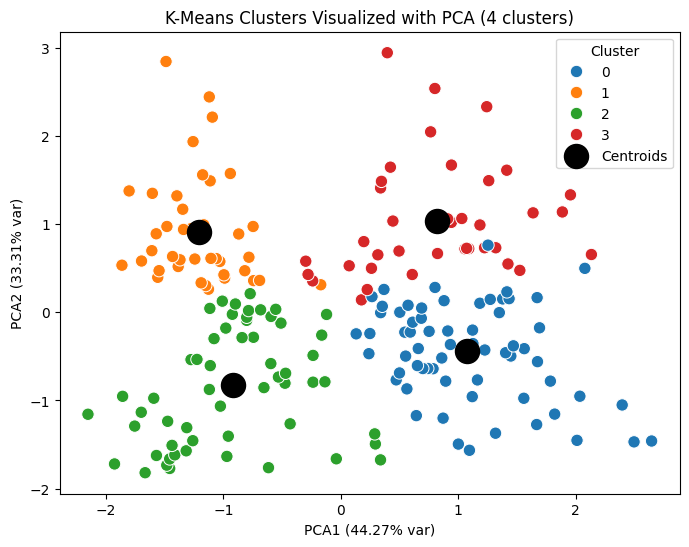

In [17]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert to DataFrame
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

kmeans = KMeans(n_clusters=4, n_init="auto", max_iter=5000, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(X_scaled)

# Transform centroids to PCA space
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Plot PCA scatter with 4 clusters and centroids
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=80)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], s=300, c='black', label='Centroids')
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.2f}% var)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.2f}% var)")
plt.title("K-Means Clusters Visualized with PCA (4 clusters)")
plt.legend(title='Cluster')
plt.show()


# Printing the inertia for the best number of clusters

In [ ]:
print(f"Inertia for k=4 clusters: {kmeans.inertia_}")

Inertia for k=4 clusters: 205.22514747675916


### The inertia of 205.23 for 4 clusters indicates that the points in each cluster are relatively close to their cluster centers, meaning the clusters are compact and well-formed. We chose 4 clusters because adding more clusters would only slightly reduce inertia, so 4 provides a good balance between simplicity and clustering quality.
